In [1]:
# proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps
# une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance
# Courbe de ARI en fonction de la semianes.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import joblib
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

In [2]:
data_final = joblib.load('data_final.joblib')
data_final.head(3)

,customer_unique_id,order_approved_at,Recency,Frequency,Monetary,review_score_mean,harvesine_distance_mean,product_category_name_english,cate_list
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,111,51,9365.40,5.0,211.646795,"[bed_bath_table, bed_bath_table, bed_bath_tabl...",bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,113,60,3915.36,4.0,203.598680,"[health_beauty, health_beauty, health_beauty, ...",health_beauty
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536,74,10087.74,3.0,151.416708,"[stationery, stationery, stationery, stationer...",stationery


In [3]:
orders = data_final.loc[:, "order_approved_at"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(7,'D'))
print("La période complète des commandes porte sur {} semaines.".format(time_delta))

La période complète des commandes porte sur 99 semaines.


In [4]:
# ordre selon la date
interval_time = 7
data_final = data_final.sort_values(by='order_approved_at')

In [5]:
initial_datetime = data_final.order_approved_at.values[0]
last_datetime = data_final.order_approved_at.values[-1]
print(initial_datetime)
print(last_datetime)
data_final.head(3)

2016-10-04T09:43:32.000000000
2018-08-29T15:10:26.000000000


,customer_unique_id,order_approved_at,Recency,Frequency,Monetary,review_score_mean,harvesine_distance_mean,product_category_name_english,cate_list
7265,14359ea0c7a105749c0a56478825b015,2016-10-04 09:43:32,694,157,11013.27,5.0,203.167274,"[consoles_games, consoles_games, consoles_game...",consoles_games
48309,87776adb449c551e74c13fc34f036105,2016-10-04 10:19:23,694,129,8927.10,5.0,286.899997,"[fashion_shoes, fashion_shoes, fashion_shoes, ...",fashion_shoes
48757,88bc832f104b6dd684a17dbb1b76e778,2016-10-04 10:25:46,694,50,7230.51,1.0,210.990154,"[housewares, housewares, housewares, houseware...",housewares


In [6]:
#from audioop import minmax

def get_data_from_datetime(timestamp, df):
    scaler = MinMaxScaler()
    data_cluster = scaler.fit_transform(df.loc[df.order_approved_at <=timestamp, ['Recency', 'Frequency', 'Monetary']])
    return pd.DataFrame(data_cluster)

In [50]:
def compute_ari_scores():
    K = 3
    time_interval = 7
    timestamp = pd.Timestamp(initial_datetime) + timedelta(days=7) 
    init_model = KMeans(K)
    init_data = get_data_from_datetime(timestamp, df=data_final)
    init_model.fit(init_data)
    init_clusters = init_model.labels_
    scores = list()

    while timestamp <= last_datetime:
        timestamp = timestamp + timedelta(days=time_interval)
        new_data = get_data_from_datetime(timestamp, df=data_final)
        new_data = new_data[new_data.index.isin(init_data.index)]
        current_model = KMeans(K).fit(new_data)
        current_clusters = current_model.labels_
        ari_score = adjusted_rand_score(init_clusters, current_clusters)
        scores.append((ari_score, timestamp))
        
    return scores

In [51]:
ari_scores = pd.DataFrame(compute_ari_scores(), columns=["ARI", "periode"])

In [52]:
semaines = list()
for i in np.arange(0, len(ari_scores), 1):
    semaines.append(i)

In [53]:
ari_scores["semaines"] = semaines
ari_scores.head(15)

,ARI,periode,semaines
0,1.000000,2016-10-18 09:43:32,0
1,1.000000,2016-10-25 09:43:32,1
2,1.000000,2016-11-01 09:43:32,2
3,1.000000,2016-11-08 09:43:32,3
4,1.000000,2016-11-15 09:43:32,4
5,1.000000,2016-11-22 09:43:32,5
6,1.000000,2016-11-29 09:43:32,6
7,1.000000,2016-12-06 09:43:32,7
8,1.000000,2016-12-13 09:43:32,8
9,1.000000,2016-12-20 09:43:32,9


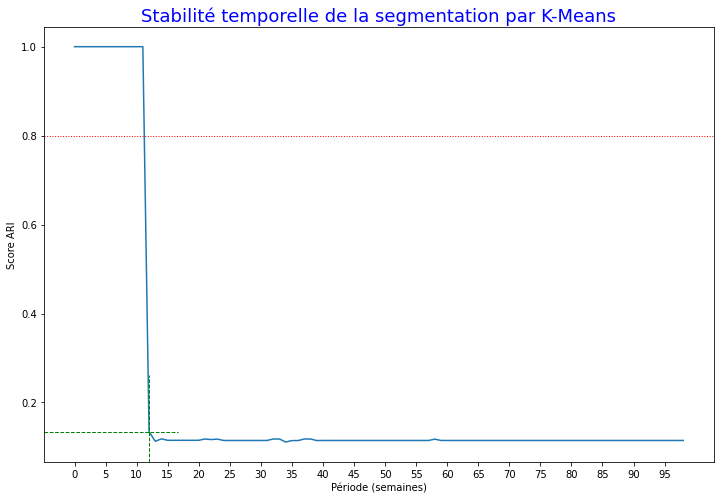

In [54]:
fig = plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ari_scores, y="ARI", x="semaines")

ax.set_xticks(np.arange(0, len(ari_scores), 5))
plt.axhline(y=ari_scores.iloc[12][0], linestyle="--", 
            color="green",
            xmax=0.2,
            linewidth=1)
plt.axhline(y=0.8, linestyle=":", 
            color="r",
            xmax=1,
            linewidth=1)
plt.axvline(x=ari_scores.iloc[12][2], linestyle="--", 
            color="green",
            ymax=0.2,
            linewidth=1)

plt.xlabel("Période (semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

On remarque une forte inflexion après 12 semianes (environ 3 mois) sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 12 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.

### La stabilité du modèle avec la mise à jour des modèles

In [12]:
def compute_ari_scores_with_update():
    K = 3
    time_interval = 7
    timestamp = pd.Timestamp(initial_datetime) + timedelta(days=7) 
    init_model = KMeans(K)
    init_data = get_data_from_datetime(timestamp, df=data_final)
    init_model.fit(init_data)
    init_clusters = init_model.labels_
    scores = list()

    while timestamp <= last_datetime:
        timestamp = timestamp + timedelta(days=time_interval)
        new_data = get_data_from_datetime(timestamp, df=data_final)
        new_data2 = new_data[new_data.index.isin(init_data.index)]
        current_model = KMeans(K).fit(new_data2)
        current_clusters = current_model.labels_
        ari_score = adjusted_rand_score(init_clusters, current_clusters)
        if ari_score < 0.8:
            init_clusters = current_clusters
            init_data = new_data2
        scores.append((ari_score, timestamp))
        
    return scores

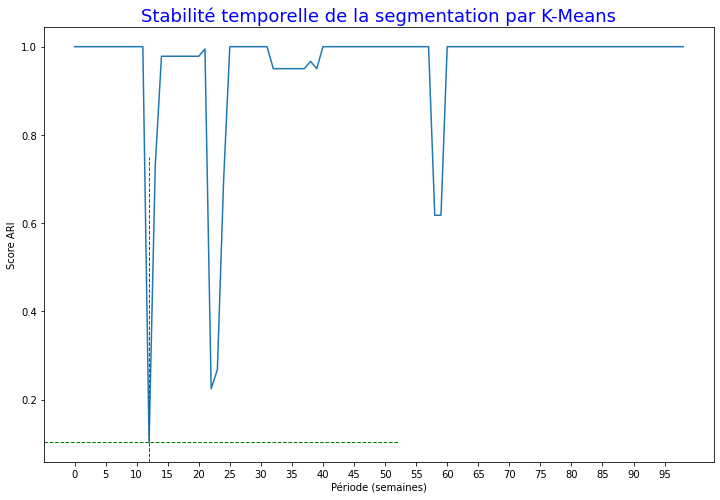

In [23]:
ari_scores_with_model_update = pd.DataFrame(compute_ari_scores_with_update(), columns=["ARI", "periode"])

semaines = list()
for i in np.arange(0, len(ari_scores_with_model_update), 1):
    semaines.append(i)

ari_scores_with_model_update["semaines"] = semaines

fig = plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ari_scores_with_model_update, y="ARI", x="semaines")
ax.set_xticks(np.arange(0, len(ari_scores), 5))

plt.axhline(y=ari_scores_with_model_update.iloc[12][0], linestyle="--", 
            color="green",
            xmax=0.53,
            linewidth=1)
plt.axvline(x=ari_scores_with_model_update.iloc[12][2], linestyle="--", 
            color="green",
            ymax=0.7,
            linewidth=1)

plt.xlabel("Période (semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()